In [1]:
from Config import Config, plot_rewards, smooth
from Env import env_agent_config, all_seed
from Utils import train, to_tensor, plot
from Agent import Agent
import d2l.torch as d2l
import torch
import random
import numpy as np

In [2]:
def test(cfg, env, agent, interval_times, noise=False):
    rewards = []  # 记录所有回合的奖励
    steps = []
    if noise:
        agent.actor.train()
    else:
        agent.actor.eval()
    for i_ep in range(cfg.test_eps):
        ep_reward = 0  # 记录一回合内的奖励
        ep_step = 0
        action = 0
        state = env.reset()  # 重置环境，返回初始状态
        unwrapped_env = env.unwrapped
        state = unwrapped_env.ale.getRAM()
        for i in range(cfg.max_steps):
            ep_step+=1
            if i % interval_times == 0:
                next_state, reward, done, _ = env.step(env.action_space.sample())
            else:
                action = agent.predict_action(state)  # 选择动作
                next_state, reward, done, _ = env.step(action)  # 更新环境，返回transition
            next_state = unwrapped_env.ale.getRAM()
            state = next_state  # 更新下一个状态
            ep_reward += reward  # 累加奖励
            if done:
                break
        steps.append(ep_step)
        rewards.append(ep_reward)
    agent.actor.train()
    env.close()
    return np.array(rewards)

In [3]:
cfg = Config() 
env, agent = env_agent_config(cfg)

/home/wyq/anaconda3/lib/python3.9/site-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment BeamRider-v0 is out of date. You should consider upgrading to version `v5` with the environment ID `ALE/BeamRider-v5`.
  logger.warn(
A.L.E: Arcade Learning Environment (version +a7a216c)
[Powered by Stella]
/home/wyq/anaconda3/lib/python3.9/site-packages/gym/utils/seeding.py:138: DeprecationWarning: WARN: Function `hash_seed(seed, max_bytes)` is marked as deprecated and will be removed in the future. 
  deprecation(
/home/wyq/anaconda3/lib/python3.9/site-packages/gym/utils/seeding.py:175: DeprecationWarning: WARN: Function `_bigint_from_bytes(bytes)` is marked as deprecated and will be removed in the future. 
  deprecation(


状态空间维度：210，动作空间维度：9


In [4]:
none_agent = torch.load('./Data/BeamRider-v0-RAM-None/1-400-500-660.0.pt')
noise_agent = torch.load('./Data/BeamRider-v0-RAM-Noise/2-400-500-660.0.pt')

In [5]:
none_mean = []
none_std = []
noise_mean = []
noise_std = []
unnoise_mean = []
unniose_std = []

In [6]:
interval = 5
for i in range(10):
    a = test(cfg, env, none_agent, interval_times=interval, noise=False)
    none_mean.append(a.mean())
    none_std.append(a.std())
    b = test(cfg, env, noise_agent, interval_times=interval, noise=True)
    noise_mean.append(b.mean())
    noise_std.append(b.std())
    c = test(cfg, env, noise_agent, interval_times=interval, noise=False)
    unnoise_mean.append(c.mean())
    unniose_std.append(c.std())

/home/wyq/anaconda3/lib/python3.9/site-packages/gym/utils/seeding.py:47: DeprecationWarning: WARN: Function `rng.randint(low, [high, size, dtype])` is marked as deprecated and will be removed in the future. Please use `rng.integers(low, [high, size, dtype])` instead.
  deprecation(


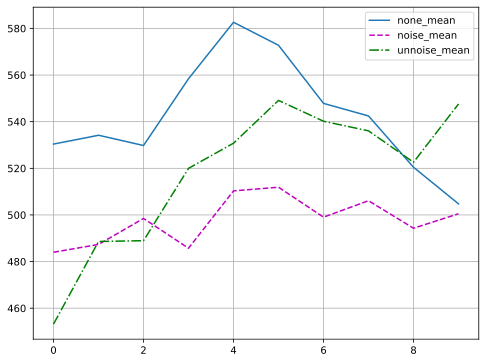

In [7]:
smooth_bool = True
weight = 0.65
X = list(range(0, len(none_mean)))
if smooth_bool:
    Y = [smooth(none_mean, weight=weight), smooth(noise_mean, weight=weight), smooth(unnoise_mean, weight=weight)]
else:
    Y = [none_mean, noise_mean, unnoise_mean]
legend = ["none_mean", "noise_mean", "unnoise_mean"]
d2l.plot(X, Y, legend=legend, figsize=(8, 6))

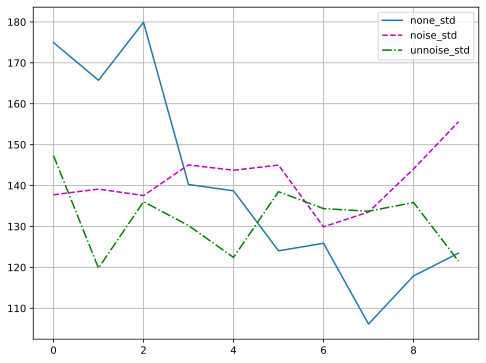

In [8]:
smooth_bool = True
X = list(range(0, len(none_mean)))
if smooth_bool:
    Y = [smooth(none_std, weight=weight), smooth(noise_std, weight=weight), smooth(unniose_std, weight=weight)]
else:
    Y = [none_std, noise_std, unniose_std]
legend = ["none_std", "noise_std", "unnoise_std"]
d2l.plot(X, Y, legend=legend, figsize=(8, 6))